# Data Collection

https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey?select=questionnaire.csv
https://wwwn.cdc.gov/Nchs/Nhanes/Search/variablelist.aspx?Component=Questionnaire&CycleBeginYear=2013

In [939]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
%matplotlib inline

import pickle

import scipy.stats as st
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.stattools import jarque_bera

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [5]:
ls DATA/

demographic.csv    examination.csv    medications.csv
diet.csv           labs.csv           questionnaire.csv


In [671]:
demo = pd.read_csv("DATA/demographic.csv")
exam = pd.read_csv("DATA/examination.csv")
medi = pd.read_csv("DATA/medications.csv", engine ='python')
diet = pd.read_csv("DATA/diet.csv")
labs = pd.read_csv("DATA/labs.csv")
ques = pd.read_csv("DATA/questionnaire.csv")

In [672]:
# Merge dataframes
df = demo.merge(exam, on='SEQN').merge(medi, on='SEQN').merge(
    diet, on='SEQN').merge(labs, on='SEQN').merge(ques, on='SEQN')


In [673]:
df = df.drop_duplicates(subset = 'SEQN')

# Dependent Variable (DV)
What I am interested in is learning the factors that affect the mental health and depressive symptoms the most. To gauge this, I will create a mental health index as DV, using the scores from the questionnaires under Mental Health - Depression Screener section. I'll also narrow down the subjects to those who have answered to have experienced at least some level of depressive symptoms. (Because we are interested in knowing how to prevent people with mental health concerns to develop serious symptoms, not about mental health of general population.)

First I'll eliminate the subjects entirely missing these scores, since we don't have any measure to infer these data. But if only some of these columns are missing, we will infer from other answers they provided.  

In [674]:
# select only depression screener columns and subject number
cols = ['SEQN'] + [c for c in df.columns if c.startswith('DPQ')]
DPQ = df.loc[:, cols]
DPQ.SEQN = DPQ.SEQN.apply(lambda x: str(x))

In [675]:
DPQ.describe()

,DPQ010,DPQ020,DPQ030,DPQ040,DPQ050,DPQ060,DPQ070,DPQ080,DPQ090,DPQ100
count,5398.000000,5396.000000,5395.000000,5395.000000,5395.000000,5394.000000,5394.000000,5394.000000,5393.000000,3674.000000
mean,0.415895,0.367865,0.618536,0.770714,0.397961,0.271598,0.289952,0.180200,0.056555,0.348122
std,0.833711,0.774571,0.964800,0.942682,0.802593,0.702979,0.722671,0.589614,0.367381,0.682270
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.000000,9.000000,7.000000,7.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000


### Data transformation 
7 is Refused to answer and 9 is don't know.  So we will turn these into nan values. 

In [676]:
DPQ = DPQ.replace(7, np.nan)
DPQ = DPQ.replace(9, np.nan)


### Missing sub-value for DV 
Each questions are rated at same scale (0-3).  

DPQ100 is conditional to have answered high on other columns (If responded to any of the other question with 1, 2 or 3) So we can safely assume that if only this value is missing, it means 0. 

If more than half of these columns (exc. DPQ100, >= 5) are missing, we will drop the subject. Otherwise, we will figure out a way to infer the measures.

In [677]:
# If DPQ100 is missing, replace it with 0.
DPQ.DPQ100 = DPQ.DPQ100.replace(np.nan, 0)

In [678]:
# If there are more than half columns missing, drop the subject.
DPQ = DPQ.drop(DPQ[DPQ.isnull().sum(axis = 1) > 4].index, axis = 0)

In [679]:
# look at the columns with missing values
DPQ.isnull().sum()

SEQN      0
DPQ010    5
DPQ020    5
DPQ030    1
DPQ040    1
DPQ050    2
DPQ060    5
DPQ070    4
DPQ080    4
DPQ090    5
DPQ100    0
dtype: int64

There are some missing values. We will replace it with the highest correlated column value.

In [680]:
# select the value that correlates the most with each columns
tmp = DPQ.dropna().iloc[:, 1:10]
cols = list(DPQ.columns)[1:10]
cor_dict = {}
for c in cols: 
    Y = tmp[c]
    X = tmp.drop(c, axis = 1)
    corr_ = X.corrwith(Y)
    max_ = corr_[corr_ == max(corr_)]
    cor_dict[c] = (list(max_.index)[0], max_[0])

In [681]:
cor_dict

{'DPQ010': ('DPQ020', 0.5317926404418502),
 'DPQ020': ('DPQ060', 0.5933182662318698),
 'DPQ030': ('DPQ040', 0.5156076939700797),
 'DPQ040': ('DPQ030', 0.5156076939700797),
 'DPQ050': ('DPQ040', 0.4471370380967231),
 'DPQ060': ('DPQ020', 0.5933182662318698),
 'DPQ070': ('DPQ020', 0.4508314640526112),
 'DPQ080': ('DPQ070', 0.4440335632622107),
 'DPQ090': ('DPQ060', 0.4098166450969543)}

In [682]:
# fill NA with the value from highest correlated questionnarie
for k, v in cor_dict.items():
    DPQ[k] = DPQ[k].fillna(DPQ[v[0]])

In [683]:
# there are a few that could not be filled (probably because both variables were empty). 
# There aren't that many so I'll drop these ones.
DPQ = DPQ.dropna(axis = 0)

In [473]:
# Fill the rest of missing values with the row means
# DPQ = DPQ.T.fillna(DPQ.mean(axis=1)).T

## Add MH_Index
The real DV I'm interested in is the total score of these measures, which I will call "MH_Index (Mental Health Index)". 
I'm using the total score instead of mean, because even though I believe each questin weighs differently in terms of how much it contributes to the idea of mental health (suicidal thought should weigh more than feeling tired), but I don't want to take the liberty of assigning these weights myself. 

In [684]:
# sum of each row as MH_Index
DPQ['MH_Index'] = DPQ.sum(axis = 1)

## Subsetting dataset
The ultimate purpose of my research is to reduce suicide rate. So I'm interested in what factors may affect the people to go from depressive symptom to suicidal thouoght. So participants who answered to not feel depressed at all are not relevant to this question. Including them may also potentially skew the model and weaken the relationship to factors that has stronger influence on people with some depressive symptoms. So I'll remove these participants. 

In [685]:
DPQ = DPQ[DPQ.DPQ020 != 0]

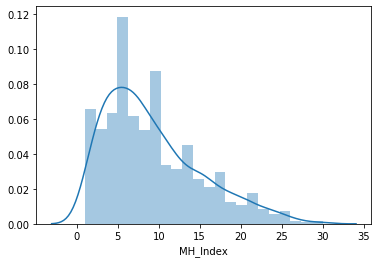

In [686]:
sns.distplot(DPQ['MH_Index'])

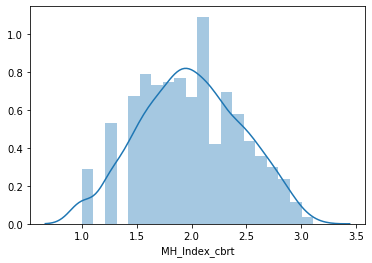

In [687]:
# log transformation
DPQ['MH_Index_cbrt'] = np.cbrt(DPQ.MH_Index)
sns.distplot(DPQ['MH_Index_cbrt'])


## Dependent Variable : MH_Index

# Selecting Independent Variables
There are over 1500 measures here. It won't make sense to run with all of these measures. So first I will look at the measures that highly correlate with the DV first, then feature engineer any other ones I think will be interesting. As a brainstorm, below are the ones I think may have influence. 

**Topics**
0. General Demographics
    - Age
    - Gender
    - Race
    - Sexual Identity
    - Income
    - Household (Family size)
    - Emplyment Status / Occupation (OCQ)
    - Education level 
    - Veterans
1. Existing Conditions
    - Disability (DLQ)
    - Physical Functioning (PFQ)
    - Medical Conditions (MCQ)
    - Sleep (SLQ)
2. Hormone Level
    - (need more research) 
3. Accessibility to Care
    - Visit to health care professional (HUQ061)
    - Visit to mental health professional (HUQ090)
4. Lifestyle (ability to maintain)
    - Physical Activity (PAQ)
    - Food security (FSQ)
5. Diet & Nutrition (CBQ/DBQ)
6. Substance Abuse (DUQ, ALQ)
7. Pregnancy


### Merging DV with features (narrow it to subset)

In [1092]:
df.SEQN = df.SEQN.astype('str')

In [1093]:
# merge DV to narrow down the subjects
MHI = DPQ[['SEQN', 'MH_Index']]
select_df = MHI.merge(df, on ="SEQN")

#### Looking at correlations
Since the IVs are not yet cleaned, this is not exactly accurate measure, but I'll use this to gauge which area to prioritize.

In [1144]:
# quick overview of correlations. 
tmp = select_df.dropna(how = 'all', axis = 1)
a = list(tmp.columns[tmp.isnull().sum() < (len(tmp)/2)]) # at least 50% of data's in.
tmp = tmp[a]
corta = tmp.corrwith(tmp['MH_Index'])

In [1149]:
sel_cols = list(corta[abs(corta).sort_values(ascending = False) > 0.3].index)

In [1150]:
sel_cols

['MH_Index',
 'HSD010',
 'DLQ040',
 'DPQ010',
 'DPQ020',
 'DPQ030',
 'DPQ040',
 'DPQ050',
 'DPQ060',
 'DPQ070',
 'DPQ080',
 'DPQ090',
 'DPQ100',
 'HUQ010',
 'PFQ049',
 'PFQ061N']

Based on these correlations and my initial list, I will focus on these features, for the sake of time.

1. Demographics
    - Especially gender and income
2. Medical conditions
    - BMI / obesity (if time, dietary choices)
    - Chronic illness 
    - Chronic illness x years of living with the disease
    - Disability / physical function
3. Substance abuse
    - Use of drug
    - Use of tobacco products
    - Use of alcohol
4. Gender x Hormone
    - any information on menstrual cycle x female
    - any information on hormone substance
   

## Demographics
Age: RIDAGEYR (in year, capped at 80)  
Gender: RIAGENDR (1: male, 2: female)  
Family Income: INDFMIN2  
Income to poverty guideline : INDFMPIR  
number of people in the household : DMDHHSIZ  
Veterans : DMQMILIZ  
Sexual Identity: SXQ294   
- Heterosexual or straight (attracted to men)  1  
    Homosexual or lesbian (attracted to women) 2  
    Bisexual (attracted to men and women)  3  
    Something else 4  
    Not sure 5  
    REFUSED  7  
    DON'T KNOW  9  
Education level: DMDHREDU  
 

### Age
Survey age was capped at 80, meaning age of anyone older was inputted as 80. To adapt to this, I'll add some noise to this data by dispersing the data with age 80 to be random integer between 80 to 90.  
Otherwise we see that it's heavy on 18 years old, and rest are more or less noisy.  

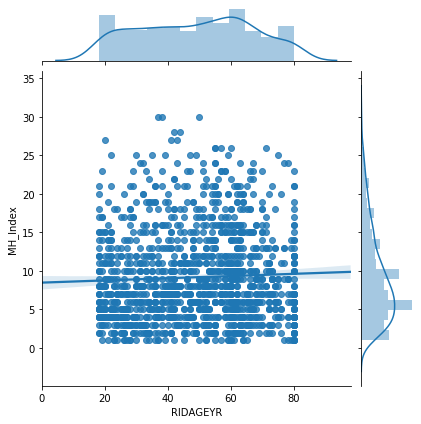

In [1196]:
sns.jointplot("RIDAGEYR", "MH_Index", data=select_df, kind="reg")

Not much relationship here.

In [1152]:
select_df['age'] = select_df.RIDAGEYR.apply(lambda x: np.random.randint(80, 90, 1)[0] if x == 80 else x)

In [1153]:
select_df.age.isnull().sum()

0

### Gender
63% of the sample are female, and they seem to have slightly higher mental health index.

In [1154]:
# column with more intuitive name
select_df = select_df.rename(columns = {"RIAGENDR":"gender"}) 

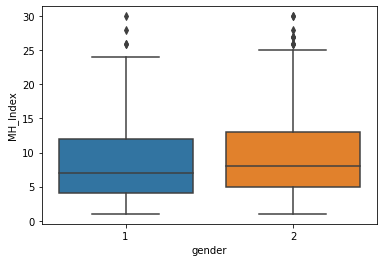

In [1156]:
sns.boxplot(x="gender", y="MH_Index", data=select_df)

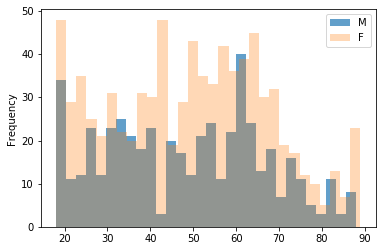

In [1157]:
select_df.age[select_df.gender == 1].plot(kind = 'hist', bins = 30, alpha = 0.7, label = "M")
select_df.age[select_df.gender == 2].plot(kind = 'hist', bins = 30, alpha = 0.3, label = "F")
plt.legend()

In [1158]:
select_df.gender.value_counts(normalize = True)

2    0.62803
1    0.37197
Name: gender, dtype: float64

In [1159]:
select_df.gender.isnull().sum()

0

### Compare genders (two sample t-test)
Let's see if the difference between the gender is significant.

In [1162]:
st.ttest_ind(select_df.MH_Index[select_df.gender == 1], select_df.MH_Index[select_df.gender == 2])

Ttest_indResult(statistic=-2.033468055645872, pvalue=0.04220525448148936)

At significance level of 0.05, MH index scores of male and female are significantly different.

### Total number of household
Most households have 2 people, followed by 3, 1, 4.

In [1164]:
select_df = select_df.rename(columns = {"DMDHHSIZ":"total_household"})

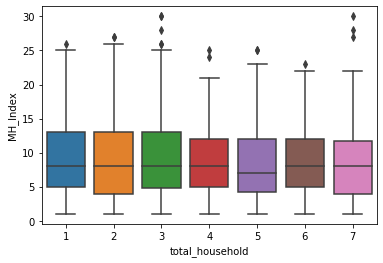

In [1165]:
sns.boxplot(x="total_household", y="MH_Index", data=select_df)

A household number does not seem to differ much.

In [862]:
select_df.total_household.isnull().sum()

0

#### Household types
I want to know in detail how different household types may affect the mental health index. Single mom and a couple are both two people households but their living situation can be very different. I'll create a new feature "n_dependents" and add up all children numbers (under 5 or under 17). Then add a new feature "n_adults", a household number subtracting children numbers, and make an interaction between the two.

In [1166]:
select_df['n_dependents'] = select_df['DMDHHSZA'] + select_df['DMDHHSZB']
select_df['n_adults'] = select_df['total_household'] - select_df['n_dependents']
select_df.n_adults.value_counts()

2    551
3    273
1    266
4    154
5     46
7     17
6     12
0      1
Name: n_adults, dtype: int64

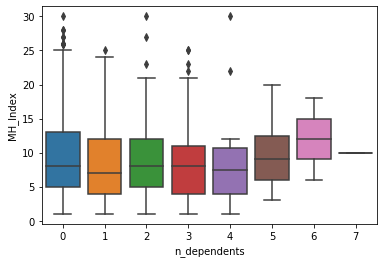

In [1167]:
sns.boxplot(x="n_dependents", y="MH_Index", data=select_df)

It seems like there could be some relationship. But residuals are not normal, so we cannot run ANOVA. We should run Kruskal Wallis.

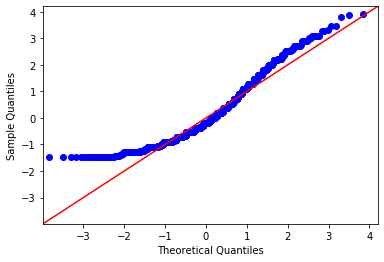

In [1179]:
mod = ols('MH_Index ~ n_dependents', data = select_df).fit()
fig = sm.qqplot(mod.resid, st.t, fit=True, line='45')

In [1238]:
x1 = select_df[select_df.n_dependents == 0].MH_Index
x2 = select_df[select_df.n_dependents == 1].MH_Index
x3 = select_df[select_df.n_dependents == 2].MH_Index
x4 = select_df[select_df.n_dependents == 3].MH_Index
x5 = select_df[select_df.n_dependents == 4].MH_Index
x6 = select_df[select_df.n_dependents == 5].MH_Index
x7 = select_df[select_df.n_dependents == 6].MH_Index

st.kruskal(x1, x2, x3, x4, x5, x6, x7)

KruskalResult(statistic=4.844837709273374, pvalue=0.56386252229861)

We failed to reject the null. It seems like the difference is not really significant.

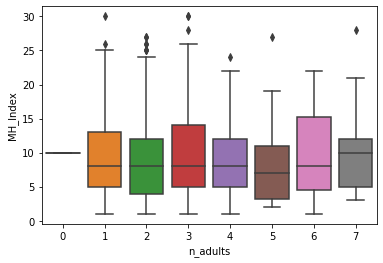

In [1168]:
sns.boxplot(x="n_adults", y="MH_Index", data=select_df)

#### Interaction
There doesn't seem to be any obvious interaction

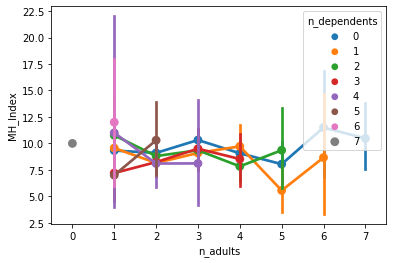

In [1189]:
# any interaction between number of adults and children?
sns.pointplot(x = 'n_adults', y = 'MH_Index', hue = 'n_dependents', data = select_df)

### Income (Total household income as a range value in dollars)
They are tiered. I'll put the mean value of the interval.

In [1190]:
# changing couple variable name to somethign more intuitive
select_df = select_df.rename(columns = {"INDFMIN2": "income"})

In [1191]:
cond = [
    select_df.income == 1, 
    select_df.income == 2, 
    select_df.income == 3, 
    select_df.income == 4, 
    select_df.income == 5, 
    select_df.income == 6, 
    select_df.income == 7, 
    select_df.income == 8, 
    select_df.income == 9, 
    select_df.income == 10, 
    select_df.income == 12, 
    select_df.income == 13, 
    select_df.income == 14, 
    select_df.income == 15 
]
vals = [np.mean([0, 4999]), np.mean([5000, 9999]), np.mean([10000, 14999]), 
       np.mean([15000, 19999]), np.mean([20000, 24999]), np.mean([25000, 34999]), 
       np.mean([35000, 44999]), np.mean([45000, 54999]), np.mean([55000, 64999]), 
       np.mean([65000, 74999]), np.mean([20000, 40000]), np.mean([0, 20000]), 
       np.mean([75000, 99999]), np.mean([100000, 200000])]

select_df['income_avg'] = np.select(cond, vals, np.nan)

In [1192]:
select_df.income_avg.isnull().sum()

57

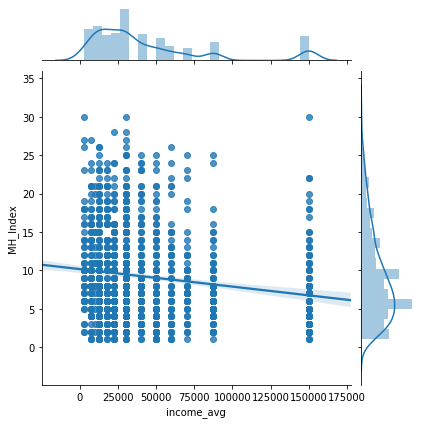

In [1215]:
sns.jointplot("income_avg", "MH_Index", data=select_df, kind="reg")

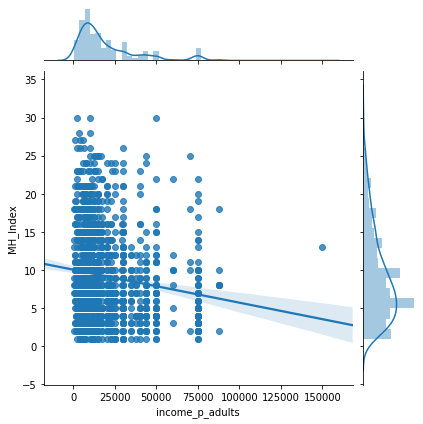

In [1216]:
tmp = select_df.copy()
tmp = tmp[tmp.n_adults != 0]
tmp['income_p_adults'] = tmp.income_avg/tmp.n_adults

sns.jointplot("income_p_adults", "MH_Index", data=tmp, kind="reg")
med_ration = tmp['income_p_adults'].median()

#### Missing values
Since distribution is skewed, I'll use the median ratio of income to number of adults for misisng incomes.  
I will calculate the income by multiplying median ratio to the number of adults

In [1209]:
select_df.income_avg = select_df.income_avg.fillna(select_df.n_adults * med_ration)

In [1210]:
# adding log transformation to even out the skew
select_df['income_avg_ln'] = np.log(select_df.income_avg)

### Income to household ratio
I will calculate income to household number ratio and add as a new feature.  

In [1211]:
select_df['Income_p_household'] = select_df['income_avg'] / select_df['total_household']

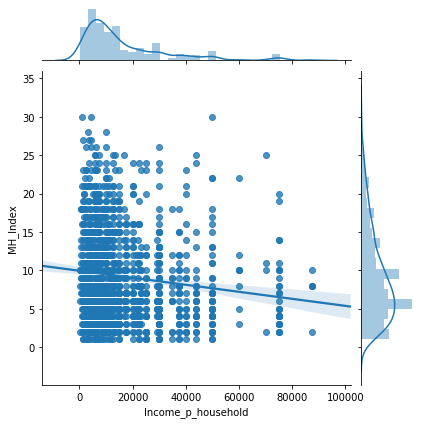

In [1217]:
sns.jointplot("Income_p_household", "MH_Index", data=select_df, kind="reg")

### Marital Status
For marital status, instead of dropping nan values, I'll add a new category 'others', for people who decided not to answer or 'don't know' the answer. And treat it as a separate category.

In [1218]:
select_df.DMDMARTL.isnull().sum()

62

In [1219]:
select_df['marital_st'] = np.where((select_df.DMDMARTL == 77) | (select_df.DMDMARTL == 77) | (select_df.DMDMARTL.isnull()), 
         0, select_df.DMDMARTL)

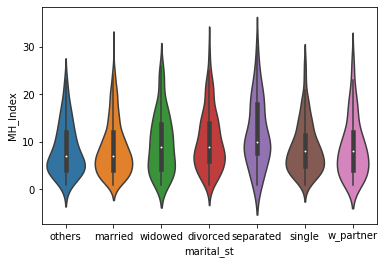

In [1221]:
sns.violinplot(x="marital_st", y="MH_Index", data=select_df)
plt.xticks([0, 1, 2, 3, 4, 5, 6], 
           labels = ['others', 'married', 'widowed', 'divorced', 
                    'separated', 'single', 'w_partner'])
plt.show()

In [874]:
select_df.marital_st.value_counts()

1.0    621
3.0    219
5.0    194
2.0    115
6.0     96
4.0     60
0.0     15
Name: marital_st, dtype: int64

### Interaction (Marital St x Age)
What about interaction between marital status and age?

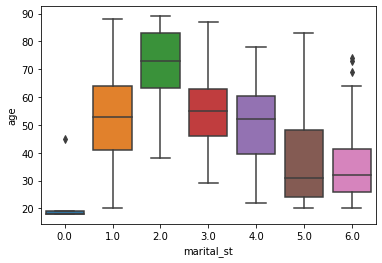

In [1243]:
sns.boxplot(x = 'marital_st', y = 'age', data = select_df)

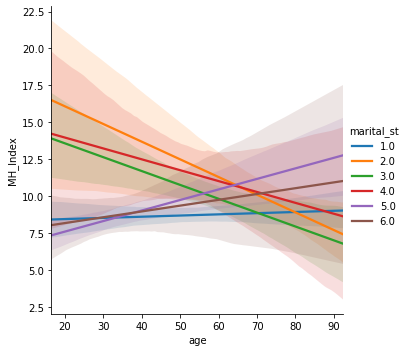

In [1295]:
sns.lmplot(x = 'age', y = 'MH_Index', hue = 'marital_st', data = select_df[select_df.marital_st != 0], scatter = False)


It's messy, but it seems like some of them may have a relationship.  
Being widowed, divorced and separated may have different relationship given age.  
I'll group widowed, divorced, and separated (WDS) as one category. Then add an interaction between WDS and age. 

In [1296]:
select_df['WDS_marital'] = np.where((select_df.marital_st == 2) | (select_df.marital_st == 3) | (select_df.marital_st == 4), 
                                   1, 0)

In [1297]:
select_df['WDSXage'] = select_df['WDS_marital'] * select_df['age']


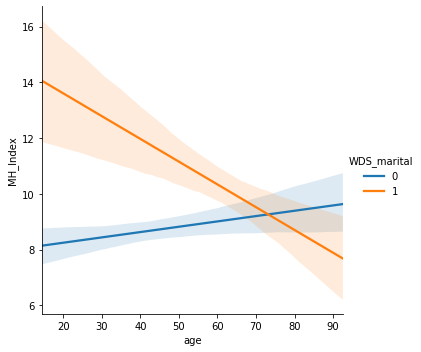

In [1299]:
sns.lmplot(x = 'age', y = 'MH_Index', hue = 'WDS_marital', data = select_df, scatter = False)


### Veterans
If they have served in US Army, 1, otherwise 0.

In [1245]:
select_df['veteran'] = np.where((select_df.DMQADFC == 1), 1, 0)

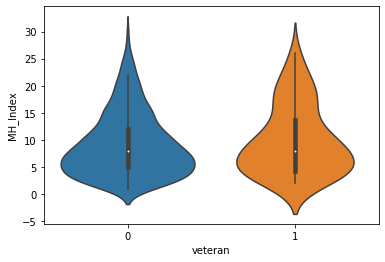

In [1229]:
sns.violinplot(x="veteran", y="MH_Index", data=select_df)

In [1230]:
st.ttest_ind(select_df.MH_Index[select_df.veteran == 1], select_df.MH_Index[select_df.veteran == 0])
# not quite significant

Ttest_indResult(statistic=0.9897946684190017, pvalue=0.3224561634044393)

### Education
There are separate questions for people age 20+, and for 18, 19 years olds. I'll combine them to create a collective category.

In [1231]:
cond = [(select_df.DMDEDUC2.isnull()) & ((select_df.DMDEDUC3 < 10) | (select_df.DMDEDUC3 == 66)  | (select_df.DMDEDUC3 == 55)),
        (select_df.DMDEDUC2.isnull()) & (select_df.DMDEDUC3 < 12),#Some HS or less
        (select_df.DMDEDUC2.isnull()) & (select_df.DMDEDUC3 <= 14),#HS & GED
        (select_df.DMDEDUC2.isnull()) & (select_df.DMDEDUC3 == 15)#Some col
       ]
vals = [1, 2, 3, 4]
select_df['education'] = np.select(cond, vals, select_df.DMDEDUC2)


In [1232]:
select_df.education.value_counts()

4.0    407
3.0    325
2.0    238
5.0    234
1.0    116
Name: education, dtype: int64

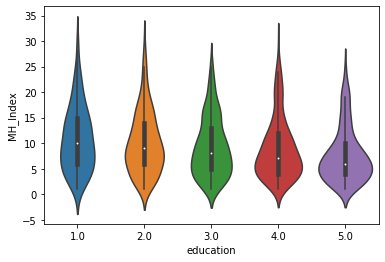

In [1249]:
sns.violinplot(x="education", y="MH_Index", data=select_df)
plt.show()

## Plotting Relationship
I'll plot relationship and build a baseline model from these demographics data first.

In [912]:
# for each columns, plot scatter plot
def mass_scatter(df, y = 'MH_Index'):
    a = len(df.columns)
    ncols = math.ceil(a**.5)
    nrows = math.ceil(a/ncols)
    fig, axes = plt.subplots(nrows = nrows, ncols = ncols, 
                             figsize = (12, 12))

    axes = axes.ravel()

    for i in range(len(df.columns)):
        axes[i].scatter(df.iloc[:, i], df[y], alpha = 0.2)
        axes[i].set_title(df.columns[i])
        axes[i].get_yaxis().set_ticks([])

In [1316]:
cols = ['MH_Index', 'gender', 'age', 'education', 'total_household', 
        'n_dependents', 'n_adults', 'income_avg_ln', 'Income_p_household', 
        'marital_st', 'veteran', 'WDS_marital', 'WDSXage']
current_df = select_df[cols]

In [997]:
#mass_scatter(current_df)

# Dummy columns
For features I want to treat as categorical values, I'll convert them into dummy binary columns.  


In [1278]:
def dummies(x, prefix):
    """
    Helper function to make dummies
    Input: series or array, prefix string
    Output: dummy dataframe
    """
    x = x.dropna(axis = 0) # drop NA and make them integers (float throws an error)
    x = x.astype('int64')
    dummy = pd.get_dummies(x, prefix = prefix, drop_first = True)
    return dummy

In [1289]:
def multi_dummy(df, cat_cols):
    for c in cat_cols: 
        dummy = dummies(df[c], c)
        df = pd.concat([df, dummy], axis = 1)
        df = df.drop(c, axis = 1)
    return df

In [1304]:
current_df.columns

Index(['MH_Index', 'gender', 'age', 'education', 'total_household',
       'n_dependents', 'n_adults', 'income_avg_ln', 'Income_p_household',
       'marital_st', 'veteran', 'WDS_marital', 'WDSXage'],
      dtype='object')

In [1317]:
cat_cols = ['gender', 'education', 'marital_st','n_dependents', 'n_adults']
# First make sure they are integer not float 

current_df = multi_dummy(current_df, cat_cols)

# Check Multicollinearity

In [1282]:
def corr_high(df):
    """
    INPUT: Pandas Dataframe
    OUTPUT: return a dataframe with the pair correlation above 0.7
    """
    corr_df = abs(df.corr()).stack().reset_index()
    corr_df.columns = ['v1', 'v2', 'c']
    return corr_df, corr_df[(corr_df.c > 0.7) & (corr_df.c < 1)].sort_values(
        by = 'c', ascending = False)

In [1318]:
corr_high(current_df)[1]

,v1,v2,c
205,WDS_marital,WDSXage,0.95829
237,WDSXage,WDS_marital,0.95829


In [1267]:
def remove_feat(df, exc_list):
    """
    INPUT: Pandas dataframe and a list of column names
    OUTPUT: dataframe without the columns in the list
    """
    df = df.drop(exc_list, axis = 1)
    return df

In [1319]:
# WDS Marital and WDSxAge highly correlate. I'll remove WDS_marital
current_df = remove_feat(current_df, ['WDS_marital'])

# testing removing interaction instead yielded lower adjusted R-squared.
# current_df = remove_feat(current_df, ['WDSXage'])


# Baseline Model
I will create a baseline model using above features and check the model using the mean value as a prediction.

In [1313]:
def simple_OLS(df, y = 'MH_Index'):
    """
    INPUT: dataframe and column name of target
    OUTPUT: print the summary and return model
    """
    X_col = list(df.columns)
    X_col.remove(y)
    formula = y + '~' + '+'.join(X_col)
    lm = ols(formula, data = df).fit()
    return lm

In [1320]:
lm0 = simple_OLS(current_df)
lm0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               MH_Index   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     3.423
Date:                Wed, 29 Jul 2020   Prob (F-statistic):           5.82e-09
Time:                        19:58:08   Log-Likelihood:                -4167.2
No. Observations:                1320   AIC:                             8392.
Df Residuals:                    1291   BIC:                             8543.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             12.5971      2.541      4.958      0.000       7.613      17.582
age                   -0.0187      0.013     -1.463      0.144      -0.044       0.006
total_household        0.4460      0.254      1.753      0.080      -0.053       0.945
income_avg_ln         -0.6530      0.322     -2.026      0.043      -1.285      -0.021
Income_p_household -6.458e-06   1.91e-05     -0.338      0.735   -4.39e-05     3.1e-05
veteran                1.6535      0.819      2.020      0.044       0.047       3.260
WDS_marital            2.3613      0.732      3.227      0.001       0.926       3.797
gender_2               0.8394      0.350      2.397      0.017       0.152       1.526
education_2           -0.5130      0.666     -0.770      0.441      -1.819       0.793
education_3           -1.4032      0.645     -2.176      0.030      -2.668      -0.138
education_4           -1.8246      0.638     -2.859      0.004      -3.077      -0.572
education_5           -2.5242      0.720     -3.507      0.000      -3.936      -1.112
marital_st_1           1.7618      0.909      1.939      0.053      -0.021       3.545
marital_st_2           0.0392      0.565      0.069      0.945      -1.070       1.148
marital_st_3           0.7787      0.444      1.755      0.079      -0.092       1.649
marital_st_4           1.5433      0.655      2.358      0.019       0.259       2.827
marital_st_5           1.1994      0.862      1.391      0.165      -0.493       2.891
marital_st_6           1.0660      0.977      1.092      0.275      -0.850       2.982
n_dependents_1        -1.2993      0.513     -2.530      0.012      -2.307      -0.292
n_dependents_2        -1.3414      0.678     -1.979      0.048      -2.671      -0.012
n_dependents_3        -2.7117      0.897     -3.024      0.003      -4.471      -0.953
n_dependents_4        -3.8793      1.445     -2.684      0.007      -6.715      -1.044
n_dependents_5        -1.6691      1.860     -0.897      0.370      -5.319       1.981
n_dependents_6        -0.5033      3.260     -0.154      0.877      -6.898       5.892
n_dependents_7        -1.0350      4.820     -0.215      0.830     -10.492       8.422
n_adults_1             2.5374      0.825      3.077      0.002       0.920       4.155
n_adults_2             2.5986      0.792      3.279      0.001       1.044       4.153
n_adults_3             3.1564      0.853      3.700      0.000       1.483       4.830
n_adults_4             1.9579      0.947      2.069      0.039       0.101       3.815
n_adults_5             0.0791      1.201      0.066      0.947      -2.277       2.435
n_adults_6             1.8587      1.798      1.034      0.301      -1.668       5.385
n_adults_7             1.4439      1.698      0.850      0.395      -1.887       4.774
======================================

Pretty poor fit we got here. Let's continue adding more meaningful features.

# Medical Condition
Now we will look at some of the existing medical condition as features.
    * BMI / obesity (if time, dietary choices)
    * Chronic illness
    * Chronic illness x years of living with the disease
    * Disability / physical function

## Obesity
### BMI

In [1327]:
select_df['BMXBMI'].isnull().sum()

14

#### Missing Value
If missing, use the gender mean. 

In [1330]:
female_mean = select_df[select_df.gender == 2].BMXBMI.mean()
male_mean = select_df[select_df.gender == 1].BMXBMI.mean()

In [1344]:
select_df['BMI'] = np.select([(select_df.BMXBMI.isnull()) & (select_df.gender == 2), 
(select_df.BMXBMI.isnull()) & (select_df.gender == 1)], [female_mean, male_mean], 
          select_df.BMXBMI)


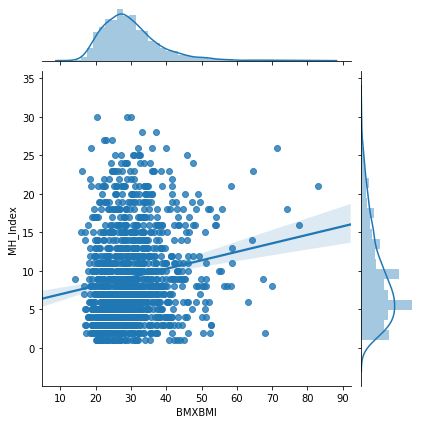

In [1332]:
sns.jointplot("BMXBMI", "MH_Index", data=select_df, kind="reg")

In [1335]:
# simple_OLS(pd.concat([current_df, select_df['BMXBMI']], axis = 1))
# adding BMI gives better fit

### Sagittal abdominal diameter 
I don't like BMI because it's not an accurate measure of healthy weight vs. not healthy weight. So I want to use BMI to infer missing sagittal abdominal diameter value but drop BMI.

In [1341]:
select_df['BMDAVSAD'].isnull().sum()

119

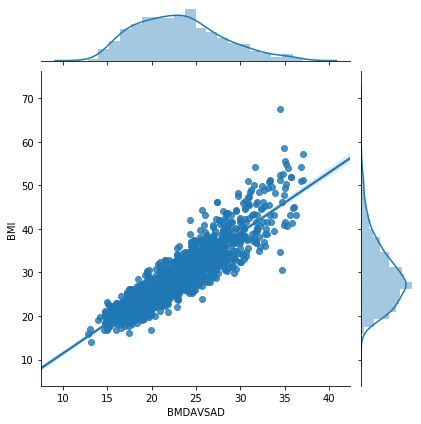

In [1373]:
sns.jointplot("BMDAVSAD", "BMI", data=select_df, kind="reg")

In [1362]:
# Average SAD / BMI ratio per gender
BMI_SAD_f = (select_df[select_df.gender == 2].BMDAVSAD/select_df[select_df.gender == 2].BMI).mean()
BMI_SAD_m = (select_df[select_df.gender == 1].BMDAVSAD/select_df[select_df.gender == 1].BMI).mean()


In [1371]:
select_df['SAD'] = np.select([(select_df.BMDAVSAD.isnull()) & (select_df.gender == 2), 
                              (select_df.BMDAVSAD.isnull()) & (select_df.gender == 1)], 
                             [BMI_SAD_f*select_df['BMI'], BMI_SAD_m*select_df['BMI']], 
                             select_df.BMDAVSAD)


In [1379]:
#simple_OLS(pd.concat([current_df, select_df['SAD']], axis = 1)).summary()
# Including SAD measure improves model fit more than including BMI

## Physical disability, functional impairements
Does functional impairement have an effect?  
For this, I will just have one binary column to avoid multicollinearity.   
If they have any physical difficulty (hearing, walking, seeing, dressing, bathing, doing errands alone), it will count as 1 otherwise 0.  

In [1380]:
select_df['disability'] = np.where((select_df.DLQ050 == 1) | (select_df.DLQ060 == 1) |
                                  (select_df.DLQ080 == 1) | (select_df.DLQ020 == 1) | 
                                  (select_df.DLQ010 == 1), 1, 0)

In [1384]:
select_df.disability.isnull().sum()

0

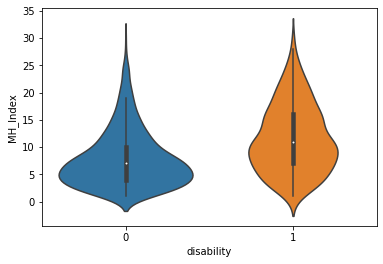

In [1381]:
sns.violinplot(x="disability", y="MH_Index", data=select_df)

In [1385]:
st.ttest_ind(select_df.MH_Index[select_df.disability == 0], 
             select_df.MH_Index[select_df.disability == 1])

# significant difference between group

Ttest_indResult(statistic=-11.753724760903479, pvalue=2.0972983905410943e-30)

In [1387]:
# simple_OLS(pd.concat([current_df, select_df['disability']], axis = 1)).summary()
# Including disability measure improved model fit a lot

## Chronic Illness
Next question is whether the person has a chronic illness and how long a person lived with this disease. (From the experience at Suicide Hotline, it seemed to me that hopelessness is often the hardest factor to cope with.)

For time being, I'll narrow it down to cancer. 